# Assignment 1
Tiny Imagenet

In [1]:
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms

from datasets import load_dataset
from myDataset import MyDataset

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 128
batch_size = 1000
num_workers = 12
prefetch_factor = 4
# print_every = 200

optim_name = "AdamW"
optim_kwargs = dict(
    lr=3e-4,
)

# preprocessing pipeline for input images
# transformation = dict()
# for data_type in ("train", "valid"):
#     is_train = data_type=="train"
#     transformation[data_type] = tv_transforms.Compose(([
#         tv_transforms.RandomRotation(degrees=15),
#         tv_transforms.RandomHorizontalFlip(),
#         tv_transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.1),
#         tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     ] if is_train else []) +
#     [
#         tv_transforms.ToTensor(),
#         tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
    
print(f"device: {device}")


device: cuda:0


In [3]:
# prepare datasets
dataset, loader = {}, {}

# cifar10
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )

# tiny-imagenet
# def to_tensor(example):
# 	return {
#         "image" : torch.tensor(example["image"].clone().detach().expand(3, -1, -1), dtype=torch.float32),
#         "label" : torch.tensor(example["label"].clone().detach(), dtype=torch.long)
#         }

def to_rgb(example):
	return {
        "image" : example["image"].convert("RGB"),
        "label" : example["label"]
        }

# def train_trans(examples):
#     examples["image"] = [transformation['train'](examples["image"]) for example in examples]
#     return examples

# def valid_trans(examples):
#     examples["image"] = [transformation['valid'](examples["image"]) for example in examples]
#     return examples

for data_type in ("train", "valid"):
    is_train = data_type=="train"
    dataset[data_type] = load_dataset("zh-plus/tiny-imagenet", split=data_type, cache_dir="./data")
    dataset[data_type] = dataset[data_type].map(to_rgb)
    # dataset[data_type] = dataset[data_type].with_format("torch")
    # dataset[data_type] = dataset[data_type].map(to_tensor)
    my_dataset = MyDataset(dataset[data_type], data_type)
    loader[data_type] = torch.utils.data.DataLoader(
        my_dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
        prefetch_factor=prefetch_factor, pin_memory=True,
    )

print(f"train sample: {len(dataset['train'])}, valid samples: {len(dataset['valid'])}")
print(f"train batches: {len(loader['train'])}, valid batches: {len(loader['valid'])}")

Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at data/zh-plus___tiny-imagenet/default/0.0.0/5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Thu Oct 30 00:48:02 2025).
Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at data/zh-plus___tiny-imagenet/default/0.0.0/5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Thu Oct 30 00:48:02 2025).


train sample: 100000, valid samples: 10000
train batches: 100, valid batches: 10


### Baseline

In [4]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(128, 200),
        )

    def forward(self, x):
        return self.model(x)


### Residual Mechanism

In [5]:
class MyResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(MyResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        if in_c != out_c:
            self.conv3 = nn.Conv2d(in_c, out_c, 1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_c)
        self.bn2 = nn.BatchNorm2d(out_c)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(y)))
        if self.conv3 is not None:
            x = self.conv3(x)
        return F.relu(x + y)

class MyResBlock2(nn.Module):
    def __init__(self, in_c, mid_c, out_c, stride=1):
        super(MyResBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_c, mid_c, 1)
        self.conv2 = nn.Conv2d(mid_c, mid_c, 3, stride=stride, padding=1)
        self.conv3 = nn.Conv2d(mid_c, out_c, 1)
        if in_c != out_c:
            self.conv4 = nn.Conv2d(in_c, out_c, 1, stride=stride)
        else:
            self.conv4 = None
        self.bn1 = nn.BatchNorm2d(mid_c)
        self.bn2 = nn.BatchNorm2d(mid_c)
        self.bn3 = nn.BatchNorm2d(out_c)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        if self.conv4 is not None:
            x = self.conv4(x)
        return F.relu(x + y)

class MyResnet(nn.Module):
    def __init__(self, num_block=1):
        super(MyResnet, self).__init__()
        self.before_res = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.res = nn.Sequential(
            MyResBlock2(64, 64, 256, 2), *[MyResBlock2(256, 64, 256) for _ in range((num_block - 1) * 1)],
            MyResBlock2(256, 128, 512, 2), *[MyResBlock2(512, 128, 512) for _ in range((num_block - 1) * 2)],
            MyResBlock2(512, 256, 1024, 2), *[MyResBlock2(1024, 256, 1024) for _ in range((num_block - 1) * 4)],
            MyResBlock2(1024, 512, 2048, 2), *[MyResBlock2(2048, 512, 2048) for _ in range((num_block - 1) * 2)],
        )
        self.after_res = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(2048, 200),
        )

    def forward(self, x):
        return self.after_res(self.res(self.before_res(x)))


### Attention

In [6]:
# our network architecture
class MyAttentionBlock(nn.Module):
    def __init__(self, d_attn, num_heads=4):
        super(MyAttentionBlock, self).__init__()
        self.num_heads = num_heads
        self.mha = nn.MultiheadAttention(embed_dim=d_attn, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Conv2d(d_attn, d_attn*4, 1), nn.ReLU(inplace=True),
            nn.Conv2d(d_attn*4, d_attn, 1),
        )
        self.bn1 = nn.BatchNorm2d(d_attn)
        self.bn2 = nn.BatchNorm2d(d_attn)

    def forward(self, x):
        B, C, W, H = x.shape
        x_flat = x.flatten(2).permute(0, 2, 1)  # B, L, C
        attn_out, _ = self.mha(x_flat, x_flat, x_flat)
        attn_out = attn_out.permute(0, 2, 1).reshape(B, C, W, H)
        attn_out = F.relu(attn_out + x)
        attn_out = self.bn1(attn_out)
        out = self.ffn(attn_out) + attn_out
        out = self.bn2(out)
        return out

class MyAttention(nn.Module):
    def __init__(self, num_block=1):
        super(MyAttention, self).__init__()
        self.before_attn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.attn = nn.Sequential(
            MyResBlock(64, 128, 2), *[MyAttentionBlock(128) for _ in range(num_block)],
            MyResBlock(128, 256, 2), *[MyAttentionBlock(256) for _ in range(num_block)],
            MyResBlock(256, 512, 2), *[MyAttentionBlock(512) for _ in range(num_block)],
        )
        self.after_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(512, 200)
        )

    def forward(self, x):
        return self.after_attn(self.attn(self.before_attn(x)))


In [7]:
# move to device
model = MyResnet(num_block=4)
# model = BaselineModel()
model.to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 50.54M


## Start Training

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]

[epoch=  1] loss: 5.4836


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]

[epoch=  2] loss: 5.3892


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=  3] loss: 5.2610


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch=  4] loss: 5.1727


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch=  5] loss: 5.1122


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch=  6] loss: 5.0615


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=  7] loss: 4.9940


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch=  8] loss: 4.9398


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=  9] loss: 4.8812


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 10] loss: 4.8325


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 11] loss: 4.7772


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 12] loss: 4.7309


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 13] loss: 4.6757


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

[epoch= 14] loss: 4.6331


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 15] loss: 4.5863


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 16] loss: 4.5403


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 17] loss: 4.5017


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 18] loss: 4.4523


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 19] loss: 4.4065


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 20] loss: 4.3577


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 21] loss: 4.3261


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 22] loss: 4.2855


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 23] loss: 4.2379


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 24] loss: 4.1976


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 25] loss: 4.1683


100%|██████████| 100/100 [00:25<00:00,  3.96it/s]

[epoch= 26] loss: 4.1217


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

[epoch= 27] loss: 4.0983


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 28] loss: 4.0445


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 29] loss: 4.0203


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 30] loss: 3.9898


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

[epoch= 31] loss: 3.9658


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 32] loss: 3.9538


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 33] loss: 3.9009


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 34] loss: 3.8803


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 35] loss: 3.8316


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 36] loss: 3.8061


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 37] loss: 3.7712


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 38] loss: 3.7493


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 39] loss: 3.7281


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 40] loss: 3.6884


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 41] loss: 3.6581


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 42] loss: 3.6392


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 43] loss: 3.6099


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 44] loss: 3.5833


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 45] loss: 3.5565


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 46] loss: 3.5455


100%|██████████| 100/100 [00:25<00:00,  3.96it/s]

[epoch= 47] loss: 3.5221


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 48] loss: 3.4849


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 49] loss: 3.4581


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

[epoch= 50] loss: 3.4309


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 51] loss: 3.4052


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 52] loss: 3.3903


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

[epoch= 53] loss: 3.3582


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

[epoch= 54] loss: 3.3306


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 55] loss: 3.3186


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 56] loss: 3.3011


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 57] loss: 3.2656


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 58] loss: 3.2427


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 59] loss: 3.2313


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 60] loss: 3.2031


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 61] loss: 3.1732


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 62] loss: 3.1559


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 63] loss: 3.1301


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 64] loss: 3.1080


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 65] loss: 3.0882


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 66] loss: 3.0666


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 67] loss: 3.0469


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 68] loss: 3.0083


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 69] loss: 3.0007


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 70] loss: 2.9737


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 71] loss: 2.9489


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 72] loss: 2.9289


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 73] loss: 2.9100


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 74] loss: 2.8969


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 75] loss: 2.8732


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 76] loss: 2.8397


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 77] loss: 2.8230


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 78] loss: 2.8225


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 79] loss: 2.8348


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 80] loss: 2.7722


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 81] loss: 2.7470


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 82] loss: 2.7072


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 83] loss: 2.7056


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 84] loss: 2.6811


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 85] loss: 2.6571


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 86] loss: 2.6300


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch= 87] loss: 2.6169


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 88] loss: 2.5982


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 89] loss: 2.5842


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch= 90] loss: 2.5614


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 91] loss: 2.5351


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

[epoch= 92] loss: 2.5222


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 93] loss: 2.5012


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

[epoch= 94] loss: 2.4923


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 95] loss: 2.4625


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 96] loss: 2.4511


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 97] loss: 2.4333


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch= 98] loss: 2.4090


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch= 99] loss: 2.3936


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch=100] loss: 2.3852


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]

[epoch=101] loss: 2.3629


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=102] loss: 2.3534


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=103] loss: 2.3502


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=104] loss: 2.3227


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch=105] loss: 2.3085


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch=106] loss: 2.2912


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch=107] loss: 2.2963


100%|██████████| 100/100 [00:25<00:00,  3.96it/s]

[epoch=108] loss: 2.2809


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch=109] loss: 2.2699


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch=110] loss: 2.2564


100%|██████████| 100/100 [00:25<00:00,  3.96it/s]

[epoch=111] loss: 2.2477


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]

[epoch=112] loss: 2.2502


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=113] loss: 2.2304


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch=114] loss: 2.2266


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch=115] loss: 2.2231


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=116] loss: 2.2193


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=117] loss: 2.2104


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch=118] loss: 2.2033


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=119] loss: 2.2037


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=120] loss: 2.2076


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch=121] loss: 2.1970


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]

[epoch=122] loss: 2.1995


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

[epoch=123] loss: 2.1968


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]

[epoch=124] loss: 2.1892


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

[epoch=125] loss: 2.1949


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

[epoch=126] loss: 2.1794


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]

[epoch=127] loss: 2.1840


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


[epoch=128] loss: 2.1935Finished Training


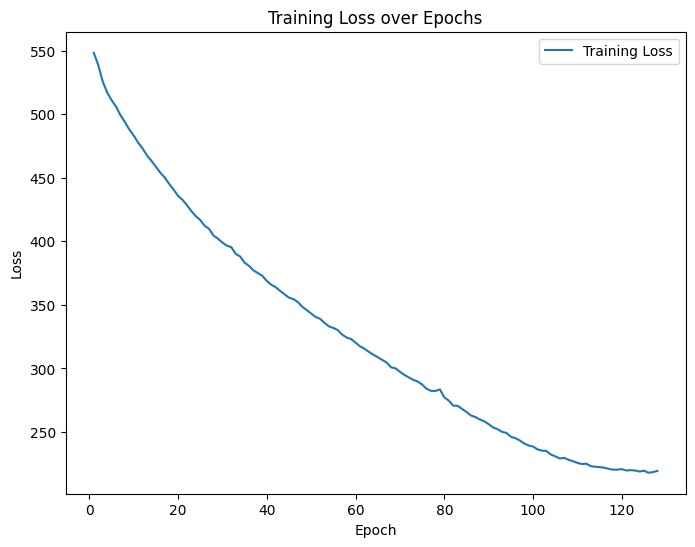

In [8]:
# the network optimizer
optimizer = getattr(optim, optim_name)(model.parameters(), **optim_kwargs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# loss function
criterion = nn.CrossEntropyLoss()

# training loop
model.train()
loss_record = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in tqdm(enumerate(loader["train"]), total=len(loader["train"])):
        img, target = batch['image'].to(device), batch['label'].to(device)

        pred = model(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % print_every == print_every - 1:
        #     print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
        #     running_loss = 0.0
    print(f"[epoch={epoch + 1:3d}] loss: {running_loss / len(loader['train']):.4f}", end='')
    loss_record.append(running_loss)
    scheduler.step()
    # break

print("Finished Training")

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_record, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


## Evaluating its accuracy

In [9]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for batch in tqdm(loader["train"], total=len(loader["train"])):
        img, target = batch['image'].to(device), batch['label'].to(device)

        # make prediction
        pred = model(img)

        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()
print(f"Accuracy of the network on the {total} train images: {100 * correct / total:.2f}%")

correct, total = 0, 0
with torch.no_grad():
    for batch in tqdm(loader["valid"], total=len(loader["valid"])):
        img, target = batch['image'].to(device), batch['label'].to(device)

        # make prediction
        pred = model(img)

        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()
print(f"Accuracy of the network on the {total} valid images: {100 * correct / total:.2f}%")

100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Accuracy of the network on the 100000 train images: 47.69%


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]

Accuracy of the network on the 10000 valid images: 38.82%
